In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # n-gram
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [99]:
file_path = './../../Fed1_dataset/Interest_rate_prediction.csv'

# FED_ir의 의미 : FED interest rate
df_irp = pd.read_csv(file_path)

df_irp.head()

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,BB_text,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM
0,2008-12-01,0.25,0.0,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,2.50,Prepared at the Federal Reserve Bank of Minnea...,0.080,0.839,0.082,0.9133,2008-12
1,2009-01-01,0.25,0.0,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-01
2,2009-02-01,0.25,0.0,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-02
3,2009-03-01,0.25,0.0,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,1.50,Prepared at the Federal Reserve Bank of San Fr...,0.083,0.839,0.078,0.5459,2009-03
4,2009-04-01,0.25,0.0,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,1.25,Prepared at the Federal Reserve Bank of Dallas...,0.092,0.826,0.082,-0.6999,2009-04


전처리

In [102]:
df_irp['DATE'] = pd.to_datetime(df_irp['DATE']) # 날짤형으로 변환

In [104]:
df_irp.dtypes

DATE            datetime64[ns]
DFEDTARU               float64
DFEDTARL               float64
IR_FORCAST             float64
GDPGR                  float64
UNRATE                 float64
PCEPI                  float64
TNX                    float64
USD                    float64
KR_IR                  float64
ECB_IR                 float64
BB_text                 object
BB_neg                 float64
BB_neu                 float64
BB_pos                 float64
BB_sentiment           float64
DATE_YM                 object
dtype: object

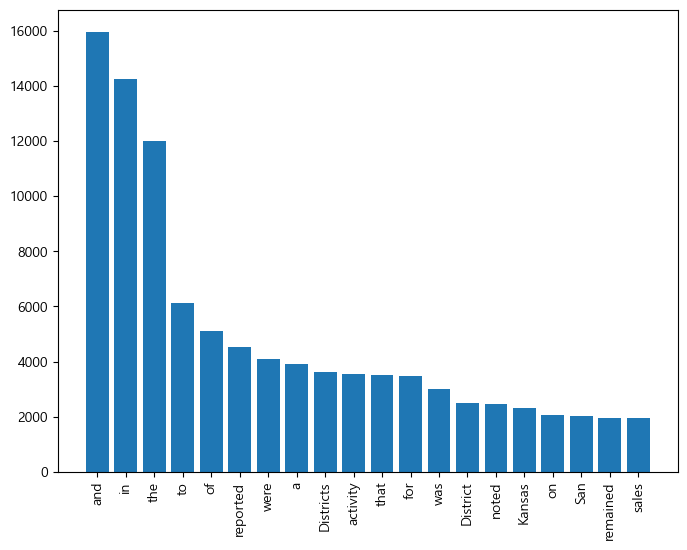

In [106]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

In [107]:
df_irp['BB_text'] = df_irp['BB_text'].str.lower()  # 소문자로
df_irp['BB_text'] = df_irp['BB_text'].str.strip()  # 앞뒤 공백 제거
df_irp['BB_text'] = df_irp['BB_text'].str.replace('\s+', ' ', regex=True)  # 중간 공백 제거
# 숫자, 대문자, 소문자 알파벳 및 공백을 제외한 모든 문자 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [110]:
# 불용어 제거
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_irp['BB_text'] = df_irp['BB_text'].apply(remove_stopwords)

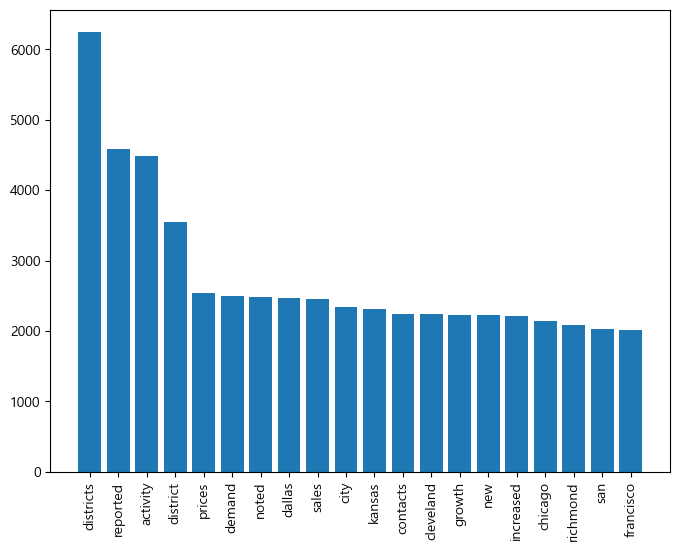

In [112]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

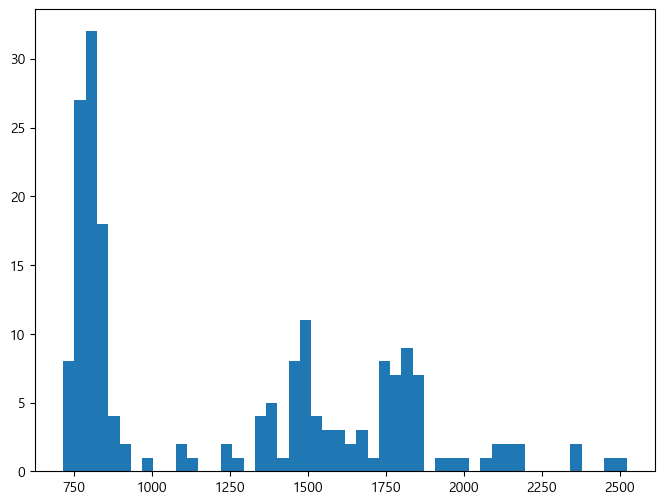

In [114]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

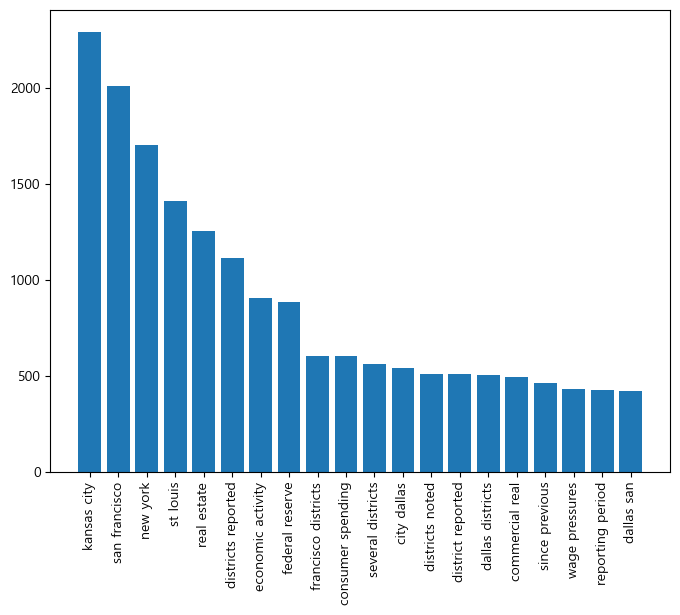

In [116]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

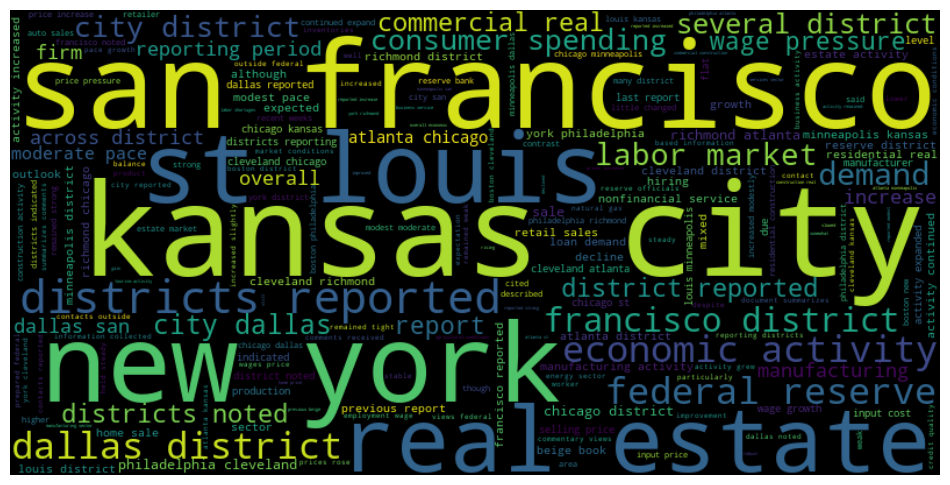

In [117]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [118]:
# 연방준비은행 지역 목록 제거st louis와 같은 경우도 감안
federal_reserve_banks = [
    "boston", 
    "new york", 
    "philadelphia", 
    "cleveland", 
    "richmond", 
    "atlanta", 
    "chicago", 
    "st. louis", 
    "minneapolis", 
    "kansas city", 
    "dallas", 
    "san francisco",
    "st",
    "louis"
]

# 연방준비은행 지역 필터링 함수
def remove_federal_reserve_banks(text, bank_list):
    # 소문자 변환 및 정규표현식을 사용하여 지역 이름 제거
    for bank in bank_list:
        bank_pattern = re.compile(re.escape(bank), re.IGNORECASE)
        text = bank_pattern.sub('', text)
    return text

# 연방준비은행 지역 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: remove_federal_reserve_banks(x, federal_reserve_banks))

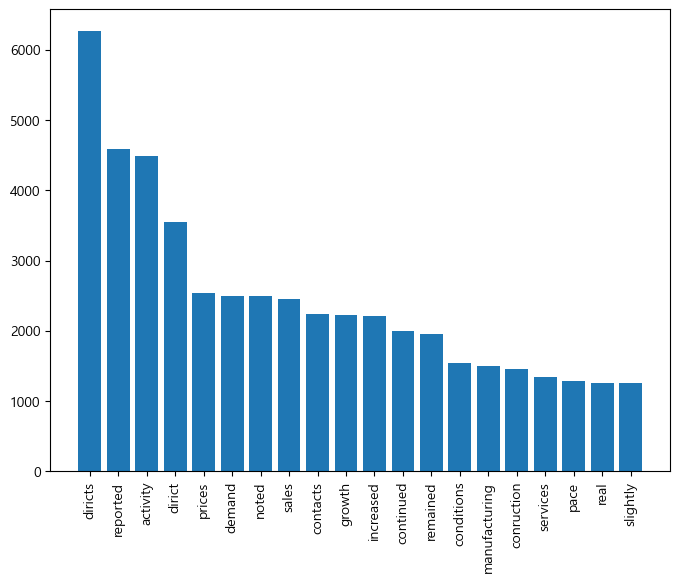

In [120]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

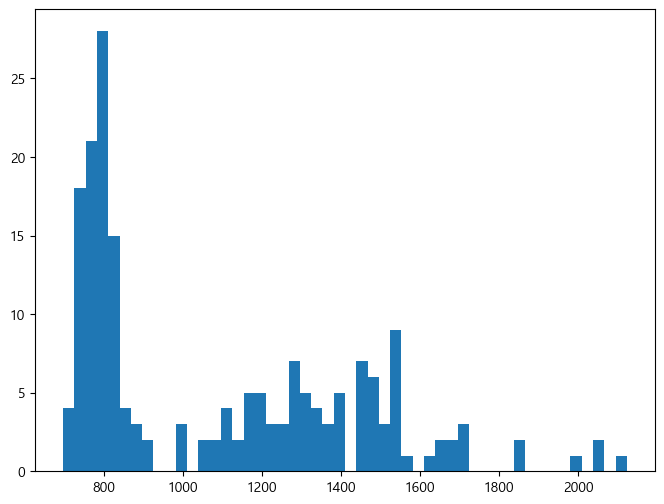

In [121]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

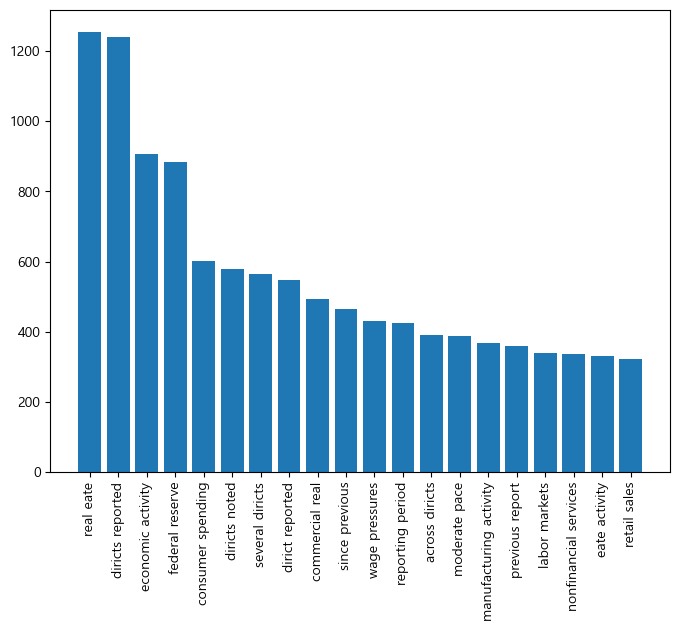

In [122]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

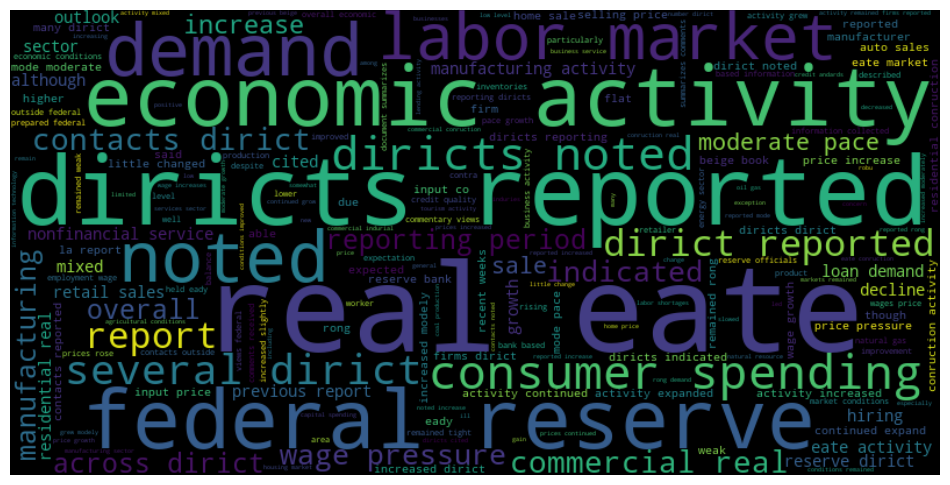

In [123]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

감정분석 : 전처리 이전과 이후 비교

In [125]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dybae\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [130]:
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']

df_irp[['f_neg', 'f_neu', 'f_pos', 'f_sentiment']] = df_irp['BB_text'].apply(lambda text: pd.Series(get_vader_sentiment(text)))

df_irp

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,...,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM,text_length,f_neg,f_neu,f_pos,f_sentiment
0,2008-12-01,0.25,0.00,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,...,0.080,0.839,0.082,0.9133,2008-12,916,0.111,0.804,0.085,-0.9594
1,2009-01-01,0.25,0.00,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,...,0.061,0.865,0.074,0.9952,2009-01,1451,0.109,0.787,0.103,-0.6317
2,2009-02-01,0.25,0.00,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,...,0.061,0.865,0.074,0.9952,2009-02,1451,0.109,0.787,0.103,-0.6317
3,2009-03-01,0.25,0.00,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,...,0.083,0.839,0.078,0.5459,2009-03,1376,0.116,0.786,0.098,-0.8791
4,2009-04-01,0.25,0.00,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,...,0.092,0.826,0.082,-0.6999,2009-04,1295,0.124,0.779,0.097,-0.9705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2024-03-01,5.50,5.25,5.50,1.4,3.8,122.782,4.206,1347.2,3.5,...,0.056,0.797,0.147,0.9991,2024-03,824,0.067,0.793,0.141,0.9966
184,2024-04-01,5.50,5.25,5.50,2.8,3.9,123.109,4.686,1382.0,3.5,...,0.068,0.807,0.126,0.9974,2024-04,790,0.071,0.813,0.117,0.9886
185,2024-05-01,5.50,5.25,5.50,2.8,4.0,123.146,4.514,1384.5,3.5,...,0.076,0.783,0.141,0.9982,2024-05,817,0.072,0.794,0.135,0.9953
186,2024-06-01,5.50,5.25,5.50,2.8,4.1,123.243,4.343,1376.7,3.5,...,0.076,0.783,0.141,0.9982,2024-06,817,0.072,0.794,0.135,0.9953


RNN

In [133]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [134]:
# 과거 데이터를 통해 미래데이터를 예측하기 때문에 MinMaxScaler 사용
def fit_trans(factor):
    scaler = MinMaxScaler()
    scaled_df_irp = scaler.fit_transform(df_irp_new[['DFEDTARU', factor]])
    return scaled_df_irp,scaler

In [137]:
def create_sequences(df_irp, sequence_length):
    sequences = []
    print(len(df_irp),',',sequence_length)
    for i in range(len(df_irp) - sequence_length):
        sequences.append(df_irp[i:i + sequence_length]) 
    return np.array(sequences)

In [138]:
def model_fit_predict(sequences,scaler) :
    X = sequences[:, :, :]
    y = sequences[:, -1, 0]
    
    split_ratio = 0.8
    train_size = int(len(X) * split_ratio)
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    model = Sequential()
    model.add(SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # LSTM과의 차이:해당코드 무 model = Sequential()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = 'acc')
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

    y_pred = model.predict(X_test)
    # Rescale the predictions and true values back to the original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 1))), axis=1))[:, 0]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]
    
    # Print the predicted and actual values
    print("Predicted DFEDTARU values:")
    print(y_pred_rescaled)
    print("Actual DFEDTARU values:")
    print(y_test_rescaled)

    return model

In [144]:
def future_predict(df,scaled_df,model,factor) :

    dic_irp = {
        'DATE': '일자',
        'DFEDTARU': '연준 기준 금리 상한',
        'DFEDTARL': '연준 기준 금리 하한',
        'IR_FORCAST': '연준 기준 금리 예측치',
        'GDPGR': '실질 국내총생산 성장률',
        'UNRATE': '실업률',
        'PCEPI': '개인 소비 지출: 체인형 가격 지수',
        'TNX': '명목이자율',
        'USD': '한은 USD환율',
        'KR_IR': '한은 기준 금리',
        'ECB_IR': 'ECB 기준 금리',
        'f_sentiment': 'Beige book 감정'
    }
    
    last_sequence = scaled_df[-sequence_length:]
    future_dates = pd.date_range(start=df_irp_new['DATE'].max(), periods=2, freq='MS')[1:]  # 2024-08-01 예측
    predictions = []
    
    for date in future_dates:
        next_pred_scaled = model.predict(last_sequence[np.newaxis, :, :])
        next_pred_rescaled = scaler.inverse_transform(np.concatenate((next_pred_scaled, np.zeros((next_pred_scaled.shape[0], 1))), axis=1))[:, 0]
        predictions.append(next_pred_rescaled[0])
        # 시퀀스를 업데이트하여 다음 예측을 준비
        last_sequence = np.append(last_sequence[1:], [[next_pred_scaled[0][0], np.nan]], axis=0)
    print(dic_irp.get(factor))
    # 예측된 미래 데이터프레임 생성
    future_df = pd.DataFrame({
        'FACTOR': dic_irp.get(factor),
        #'DATE': future_dates,
        'REAL': 5.25,
        'PREDICT': [round(pred, 2) for pred in predictions],
        'DIFF': [round(5.25 - pred, 2) for pred in predictions]
    })

    # 기존 파일에서 데이터 읽어오기 (파일이 존재하지 않는 경우 예외 처리)
    try:
        existing_df = pd.read_csv('./../../result1/result_factor_202408.csv', encoding='utf-8-sig')
        combined_df = pd.concat([existing_df, future_df], ignore_index=True)
    except FileNotFoundError:
        combined_df = future_df
    
    # 결과를 CSV 파일로 저장
    combined_df.to_csv('./../../result1/result_factor_202408.csv', index=False, encoding='utf-8-sig')

In [146]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트
lst_factor = ['IR_FORCAST', 'GDPGR', 'UNRATE', 'PCEPI', 'TNX', 'USD', 'KR_IR', 'ECB_IR', 'f_sentiment']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 12 # 과거 12개 데이터 사용
    sequences = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(sequences,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    print(df_irp_new.head())
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

188 , 12
Epoch 1/100
4/4 [==============================] - 1s 58ms/step - loss: 0.0706 - acc: 0.5952 - val_loss: 0.0984 - val_acc: 0.8571
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0550 - acc: 0.5873 - val_loss: 0.0518 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0320 - acc: 0.5873 - val_loss: 0.0255 - val_acc: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0296 - acc: 0.5952 - val_loss: 0.0177 - val_acc: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0241 - acc: 0.5952 - val_loss: 0.0221 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0131 - acc: 0.5952 - val_loss: 0.0139 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0137 - acc: 0.5952 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0142 - 

PermissionError: [Errno 13] Permission denied: './../../result1/result_factor_202408.csv'